# Introducción al Proyecto de Machine Learning

En este proyecto, estamos desarrollando un modelo de aprendizaje automático utilizando Redes Neuronales Gráficas Heterogéneas (HeteroGNN) para predecir los valores de std (score) de los ligandos cuando interactúan con proteínas. El objetivo principal es construir un modelo que pueda aprender y generalizar las características de estas interacciones para proporcionar predicciones precisas de los scores de los ligandos.

## Descripción del Proyecto

### Datos

Los datos utilizados en este proyecto provienen de un archivo CSV que contiene información detallada sobre las características de los ligandos y las proteínas, así como sus posiciones y scores. Cada entrada en el CSV representa una interacción específica entre un ligando y múltiples proteínas.

### Modelo

El modelo que estamos utilizando es una HeteroGNN, que es capaz de manejar grafos heterogéneos con diferentes tipos de nodos y aristas. En nuestro caso, tenemos dos tipos de nodos: "ligand" y "protein", y dos tipos de aristas: "ligand2protein" y "protein2ligand".

### Proceso de Entrenamiento

1. **Carga y Preprocesamiento de Datos**: Los datos se cargan desde el CSV y se transforman en grafos heterogéneos utilizando la biblioteca `torch_geometric`. Cada grafo representa un modelo específico con nodos de tipo "ligand" y "protein", y aristas que representan las interacciones entre ellos.

2. **División de Datos**: Los grafos se dividen en conjuntos de entrenamiento, validación y prueba para evaluar el rendimiento del modelo.

3. **Definición del Modelo**: El modelo HeteroGNN se define utilizando capas convolucionales específicas para grafos heterogéneos. Estas capas permiten que el modelo aprenda las características de los nodos y las relaciones entre ellos.

4. **Entrenamiento del Modelo**: El modelo se entrena utilizando un optimizador Adam y una función de pérdida MSELoss. Durante el entrenamiento, el modelo ajusta sus parámetros para minimizar la diferencia entre las predicciones y los scores reales de los ligandos.

5. **Evaluación del Modelo**: Después del entrenamiento, el modelo se evalúa en el conjunto de prueba utilizando métricas como el error cuadrático medio (MSE), el error absoluto medio (MAE) y el coeficiente de determinación (R2).

### Resultados

Los resultados del modelo se analizan para determinar su precisión y capacidad de generalización. Las métricas de evaluación proporcionan una visión clara del rendimiento del modelo y su capacidad para predecir los scores de los ligandos en nuevas interacciones con proteínas.

Este proyecto demuestra el potencial de las HeteroGNNs para abordar problemas complejos en el ámbito de la bioinformática y la química computacional, proporcionando predicciones precisas y útiles para la investigación y el desarrollo de nuevos fármacos.

In [8]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
import math

def parse_feature(value):
    """
    Transforma un valor dado en una lista de floats.
    - Si es cadena con ';', la separa y parsea cada parte como float.
    - Si es cadena numérica, la convierte a float.
    - Si es NaN o None, retorna [0.0].
    - Si es numérico, lo mete en una lista [float(value)].
    """
    if pd.isna(value):
        return [0.0]
    if isinstance(value, str):
        if ';' in value:
            return [float(x) for x in value.split(';')]
        else:
            return [float(value)]
    return [float(value)]

def create_hetero_graphs_from_csv(csv_path: str, max_proteins: int = 50):
    """
    Carga un CSV y retorna un diccionario { modelo: HeteroData }, 
    donde cada modelo tiene un grafo heterogéneo con nodos "ligand" y "protein",
    y dos tipos de aristas: ligando->proteína y proteína->ligando.
    """
    df = pd.read_csv(csv_path)

    ligand_cols = [
        "002_htype_ligando",
        "003_irr_ligando",
        "004_sasa_ligando",
        "005_dssp_ligando",
        "006_mol_ligando",
        "008_x_ligando",
        "009_y_ligando",
        "010_z_ligando",
    ]
    protein_suffixes = [
        "_dssp",
        "_htype",
        "_irr",
        "_mol",
        "_sasa",
        "_x",
        "_y",
        "_z",
    ]

    modelos = df["000_modelo"].unique()
    hetero_graphs = {}

    for modelo in modelos:
        sub_df = df[df["000_modelo"] == modelo].reset_index(drop=True)
        data = HeteroData()

        ligand_features = []
        ligand_positions = []
        ligand_score = []

        # Para no duplicar nodos "protein", llevamos un mapeo coords -> idx
        protein_map = {}
        protein_features = []

        # Almacenan las aristas ligando->proteína y también proteína->ligando
        edge_lig2prot_src = []
        edge_lig2prot_dst = []
        edge_prot2lig_src = []
        edge_prot2lig_dst = []

        for i, row in sub_df.iterrows():
            # =============== Features de LIGAND ===============
            feats_lig = []
            for col in ligand_cols:
                parsed_vals = parse_feature(row[col])
                feats_lig.extend(parsed_vals)
            ligand_features.append(torch.tensor(feats_lig, dtype=torch.float32))

            # Score (lo tomamos de la columna "007_score_ligando")
            score_val = parse_feature(row["007_score_ligando"])[0]
            ligand_score.append(score_val)

            # Guardamos coords del ligando
            x_lig = parse_feature(row["008_x_ligando"])[0]
            y_lig = parse_feature(row["009_y_ligando"])[0]
            z_lig = parse_feature(row["010_z_ligando"])[0]
            ligand_positions.append((x_lig, y_lig, z_lig))

            # =============== Features de PROTEIN ===============
            for p_idx in range(1, max_proteins + 1):
                col_root = f"protein_{p_idx:03d}"
                col_x = col_root + "_x"
                if col_x not in row or pd.isna(row[col_x]):
                    # Significa que no hay protein_{p_idx}
                    continue
                
                prot_feats_list = []
                prot_x, prot_y, prot_z = None, None, None

                for s in protein_suffixes:
                    c = col_root + s
                    if c in row and not pd.isna(row[c]):
                        vals = parse_feature(row[c])
                        prot_feats_list.extend(vals)
                        if s == "_x": prot_x = vals[0]
                        if s == "_y": prot_y = vals[0]
                        if s == "_z": prot_z = vals[0]
                    else:
                        # Si no hay dato, se mete 0.0
                        prot_feats_list.append(0.0)

                # Verificamos coords
                if prot_x is None or prot_y is None or prot_z is None:
                    continue

                coords = (prot_x, prot_y, prot_z)
                if coords not in protein_map:
                    prot_idx = len(protein_features)
                    protein_map[coords] = prot_idx
                    protein_features.append(torch.tensor(prot_feats_list, dtype=torch.float32))
                else:
                    prot_idx = protein_map[coords]

                # Añadimos aristas ligando->protein y protein->ligando
                edge_lig2prot_src.append(i)         # i es idx del ligando en "ligand"
                edge_lig2prot_dst.append(prot_idx)  # prot_idx es idx del nodo "protein"

                edge_prot2lig_src.append(prot_idx)
                edge_prot2lig_dst.append(i)

        # =============== Asignar tensores a HeteroData ===============
        # Nodos ligand
        if len(ligand_features) > 0:
            data["ligand"].x = torch.stack(ligand_features, dim=0)  # [num_ligands, feat_dim]
            data["ligand"].y = torch.tensor(ligand_score, dtype=torch.float32).view(-1, 1)
            data["ligand"].pos = torch.tensor(ligand_positions, dtype=torch.float32)
        else:
            data["ligand"].x = torch.empty((0, 0), dtype=torch.float32)
            data["ligand"].y = torch.empty((0, 1), dtype=torch.float32)
            data["ligand"].pos = torch.empty((0, 3), dtype=torch.float32)

        # Nodos protein
        if len(protein_features) > 0:
            data["protein"].x = torch.stack(protein_features, dim=0)
        else:
            data["protein"].x = torch.empty((0, len(protein_suffixes)), dtype=torch.float32)

        # Aristas: ligando->protein
        if len(edge_lig2prot_src) > 0:
            edge_index_l2p = torch.tensor(
                [edge_lig2prot_src, edge_lig2prot_dst], dtype=torch.long
            )
            data["ligand", "ligand2protein", "protein"].edge_index = edge_index_l2p

        # Aristas: protein->ligando (relación inversa)
        if len(edge_prot2lig_src) > 0:
            edge_index_p2l = torch.tensor(
                [edge_prot2lig_src, edge_prot2lig_dst], dtype=torch.long
            )
            data["protein", "protein2ligand", "ligand"].edge_index = edge_index_p2l

        hetero_graphs[modelo] = data

    return hetero_graphs


# =======================
# EJEMPLO: Hetero GNN
# =======================

import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, GCNConv, global_mean_pool
from torch_geometric.nn import SAGEConv


class HeteroGraphScorePredictor(torch.nn.Module):
    def __init__(self, hidden_dim, out_dim=1):
        super().__init__()

        self.ligand_transform = torch.nn.Linear(16, hidden_dim)  # 16 características de ligandos
        self.protein_transform = torch.nn.Linear(16, hidden_dim)  # 16 características de proteínas

        self.conv1 = HeteroConv({
            ('ligand', 'ligand2protein', 'protein'): SAGEConv(hidden_dim, hidden_dim),
            ('protein', 'protein2ligand', 'ligand'): SAGEConv(hidden_dim, hidden_dim),
        }, aggr='sum')

        self.conv2 = HeteroConv({
            ('ligand', 'ligand2protein', 'protein'): SAGEConv(hidden_dim, hidden_dim),
            ('protein', 'protein2ligand', 'ligand'): SAGEConv(hidden_dim, hidden_dim),
        }, aggr='sum')

        self.conv3 = HeteroConv({
            ('ligand', 'ligand2protein', 'protein'): SAGEConv(hidden_dim, hidden_dim),
            ('protein', 'protein2ligand', 'ligand'): SAGEConv(hidden_dim, hidden_dim),
        }, aggr='sum')

        self.conv4 = HeteroConv({
            ('ligand', 'ligand2protein', 'protein'): SAGEConv(hidden_dim, hidden_dim),
            ('protein', 'protein2ligand', 'ligand'): SAGEConv(hidden_dim, hidden_dim),
        }, aggr='sum')

        # Capa final: Solo aplicada a los ligandos para predecir sus scores
        self.linear_lig = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x_dict = data.x_dict
        edge_dict = data.edge_index_dict

        # Transformación inicial de características
        x_dict['ligand'] = self.ligand_transform(x_dict['ligand'])
        x_dict['protein'] = self.protein_transform(x_dict['protein'])
        def swish(x):
            return x * torch.sigmoid(x)
        
        # Pasamos por las capas convolucionales
        x_dict = self.conv1(x_dict, edge_dict)
        x_dict = {k: swish(v) for k, v in x_dict.items()}

        x_dict = self.conv2(x_dict, edge_dict)
        x_dict = {k: swish(v) for k, v in x_dict.items()}

        x_dict = self.conv3(x_dict, edge_dict)
        x_dict = {k: swish(v) for k, v in x_dict.items()}

        x_dict = self.conv4(x_dict, edge_dict)
        x_dict = {k: swish(v) for k, v in x_dict.items()}

        # 🚨 SOLO predecimos para los ligandos
        out = self.linear_lig(x_dict['ligand'])  # shape: [num_ligands, 1]
        return out.view(-1)  # Devolvemos un tensor 1D con un score por cada ligando

# 1) Cargamos los grafos (cada modelo = 1 HeteroData)
graphs = create_hetero_graphs_from_csv("output.csv")



/tmp/ipykernel_330272/1193740854.py:29: DtypeWarning: Columns (390,391,392,393,399,400,401,402,408,409,410,411,417,418,419,420,426,427,428,429) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


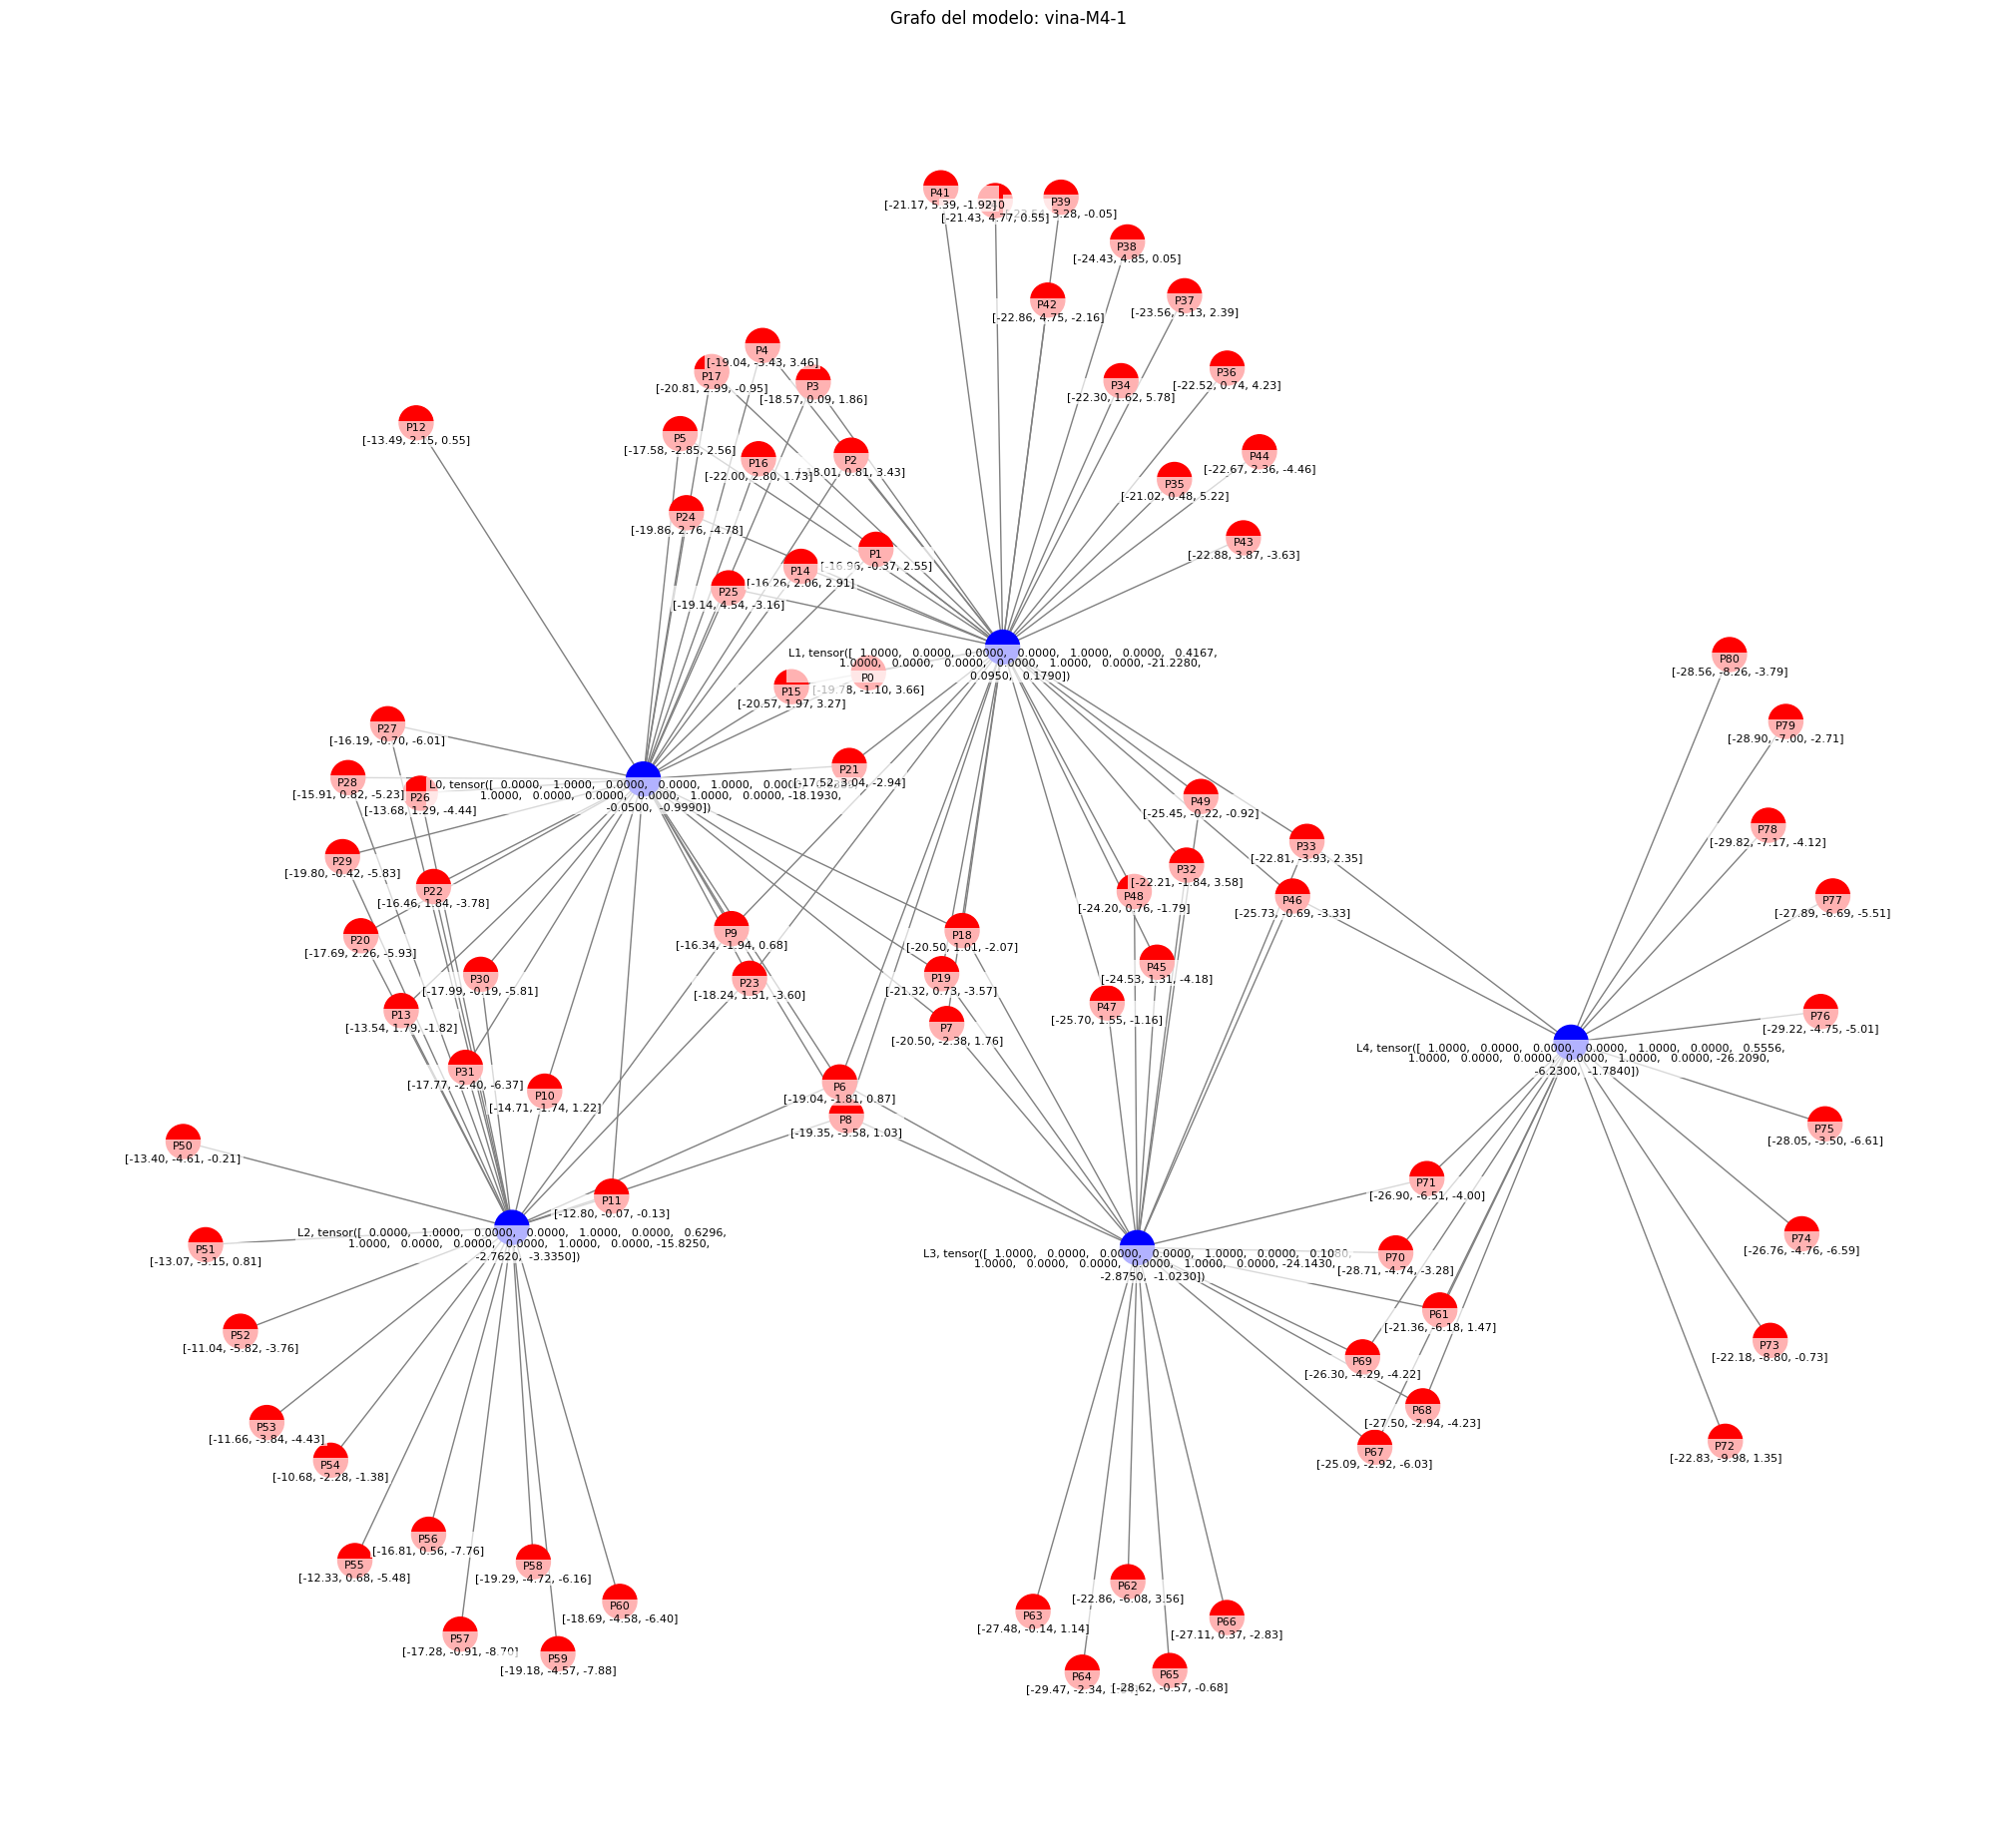

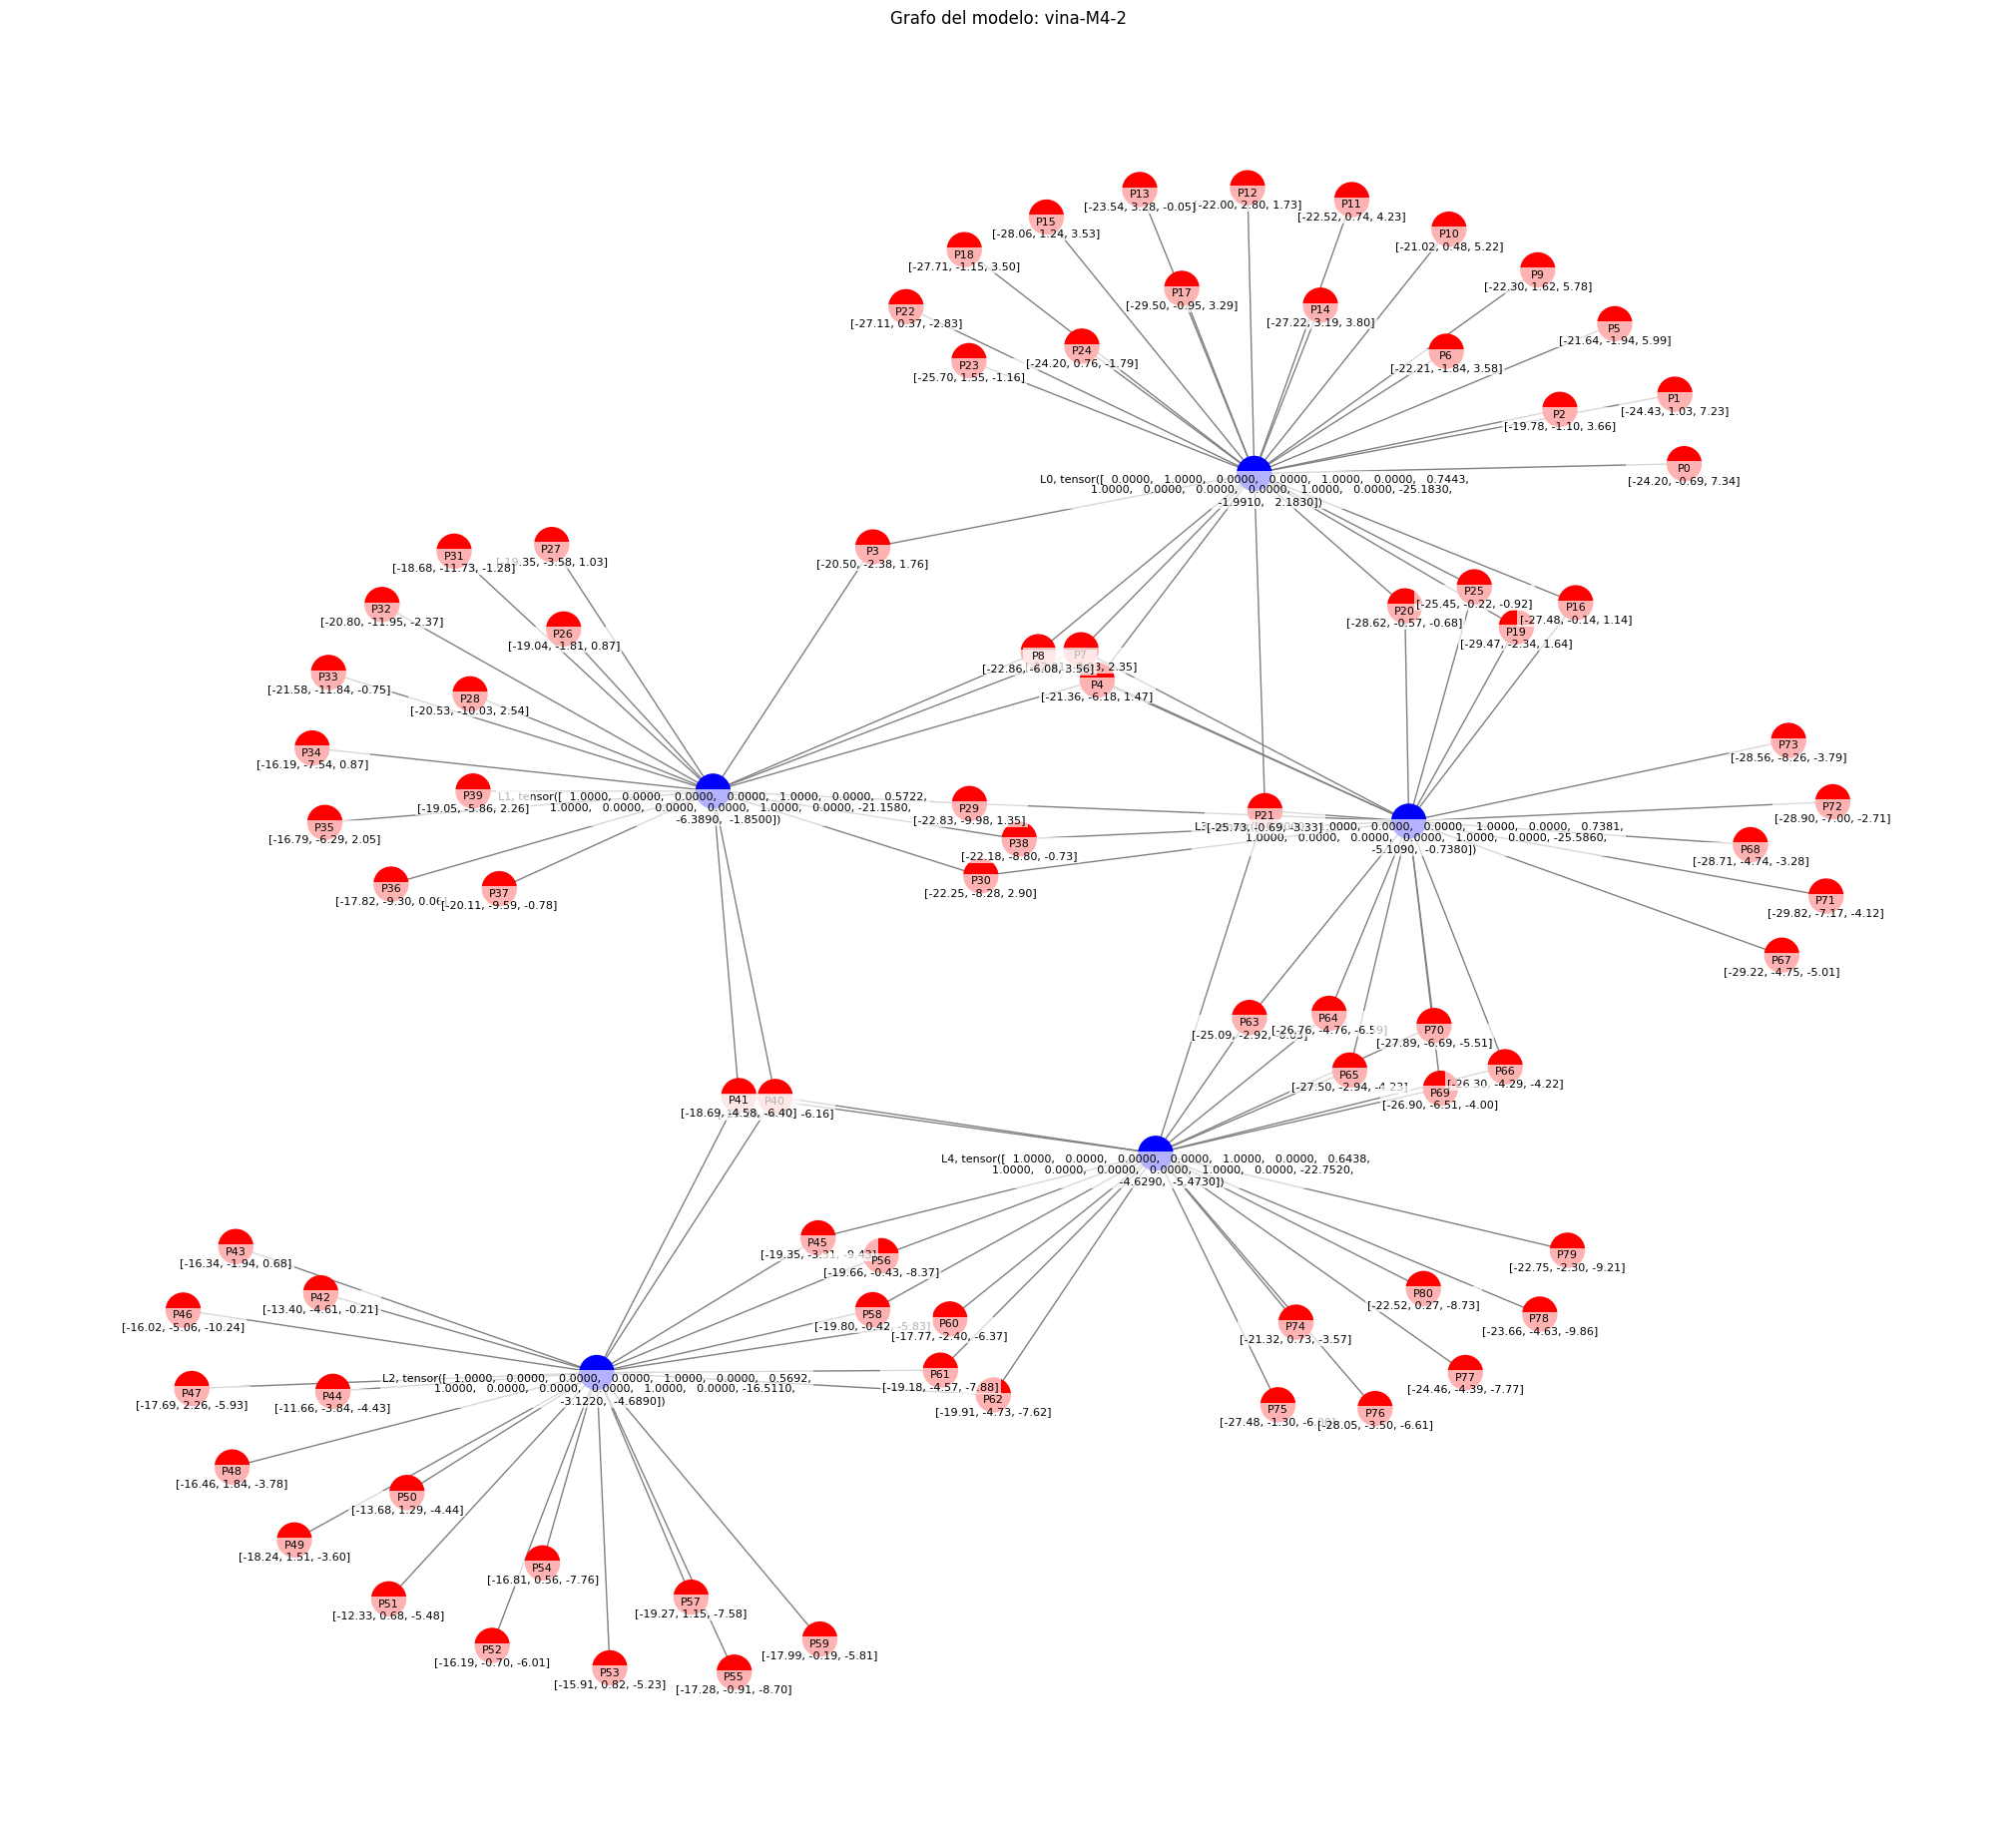

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_hetero_graphs_with_labels(hetero_graphs, max_features=5, max_graphs_show=2):
    """
    Visualiza cada HeteroData como un grafo de NetworkX, colocando etiquetas 
    detalladas para los nodos de tipo 'protein', incluyendo un resumen de sus features.
    Parámetros:
      - hetero_graphs: dict {modelo: HeteroData}
      - max_features: cuántas primeras features imprimir para no sobrecargar la etiqueta
    """
    m=0
    for modelo, data in hetero_graphs.items():
        # Creamos un grafo (puede ser Graph() si queremos sin dirección)
        G = nx.Graph()

        # A) Nodos "ligand"
        num_ligands = data['ligand'].x.size(0)
        for i in range(num_ligands):
            G.add_node((i, 'ligand'))
        
        # B) Nodos "protein"
        num_proteins = data['protein'].x.size(0)
        for i in range(num_proteins):
            G.add_node((i, 'protein'))

        # C) Aristas ligando->proteína
        if ('ligand', 'ligand2protein', 'protein') in data.edge_index_dict:
            edge_index_l2p = data['ligand', 'ligand2protein', 'protein'].edge_index
            for src, dst in edge_index_l2p.T:
                G.add_edge((src.item(), 'ligand'), (dst.item(), 'protein'))

        # D) Aristas proteína->ligando
        if ('protein', 'protein2ligand', 'ligand') in data.edge_index_dict:
            edge_index_p2l = data['protein', 'protein2ligand', 'ligand'].edge_index
            for src, dst in edge_index_p2l.T:
                G.add_edge((src.item(), 'protein'), (dst.item(), 'ligand'))
        
        # ============================
        # 1) Layout del grafo
        # ============================
        # Con muchos nodos, la vista se puede saturar. Spring layout suele distribuirlos
        # tratando de evitar choques. Puedes probar otros: circular_layout, shell_layout, etc.
        pos = nx.kamada_kawai_layout(G)
        # Ajustar "k" puede ayudarte a espaciar más los nodos.

        # ============================
        # 2) Diccionario de etiquetas
        # ============================
        # - Los nodos 'ligand' tendrán una etiqueta sencilla (p.ej. "L_i").
        # - Los nodos 'protein' mostrarán un resumen de sus features.

        labels_dict = {}

        # a) Etiquetas para ligandos
        for i in range(num_ligands):
            labels_dict[(i, 'ligand')] = f"L{i}, {(data['ligand'].x)[i]}"

        # b) Etiquetas para proteínas
        #    Tomamos sus características y las convertimos en string
        protein_features = data['protein'].x  # shape [num_proteins, feat_dim]
        for i in range(num_proteins):
            # print(protein_features[i][13])
            feats_list = [protein_features[i][13], protein_features[i][14], protein_features[i][15]]
            # Convertimos a lista
            # feats_list = feats_tensor.tolist()

            # Si tienes muchísimas features, es preferible mostrar solo las primeras N
            # o un resumen. Ejemplo: "0.12, -0.35, 1.10, ..."
            if len(feats_list) > max_features:
                feats_str = ", ".join([f"{val:.2f}" for val in feats_list[:max_features]])
                feats_str += ", ..."
            else:
                feats_str = ", ".join([f"{val:.2f}" for val in feats_list])

            # Construimos la etiqueta
            labels_dict[(i, 'protein')] = f"P{i}\n[{feats_str}]"

        # ============================
        # 3) Definir colores para nodos
        # ============================
        node_colors = []
        for node in G.nodes():
            # node es (idx, 'ligand'|'protein')
            if node[1] == 'ligand':
                node_colors.append('blue')
            else:
                node_colors.append('red')

        # ============================
        # 4) Dibujar
        # ============================
        plt.figure(figsize=(20, 18))
        
        # Dibuja nodos y aristas (sin etiquetas)
        nx.draw(
            G, pos, 
            with_labels=False,   # No ponemos labels aquí porque queremos personalizarlos
            node_size=600,
            node_color=node_colors,
            edge_color='gray',
        )

        # Dibuja las etiquetas que definimos en labels_dict
        nx.draw_networkx_labels(
            G, pos, 
            labels=labels_dict,
            font_size=8,
            verticalalignment='top',  # para que las etiquetas no se sobrepongan al nodo
            bbox=dict(boxstyle="square,pad=0.2", fc="white", ec="none", alpha=0.7)
        )

        plt.title(f"Grafo del modelo: {modelo}")
        plt.axis('off')
        plt.show()
        m+=1
        if m == max_graphs_show:
            return

# Uso:
visualize_hetero_graphs_with_labels(graphs, max_features=5, max_graphs_show=2)


In [14]:
from sklearn.model_selection import train_test_split

# 2) Convertimos el dict en lista (para DataLoader)
graph_list = list(graphs.values())

# Dividir en entrenamiento (70%), validación (15%) y prueba (15%)
train_graphs, test_graphs = train_test_split(graph_list, test_size=0.30, random_state=42)
val_graphs, test_graphs = train_test_split(test_graphs, test_size=0.5, random_state=42)

print(f"Train: {len(train_graphs)}, Validation: {len(val_graphs)}, Test: {len(test_graphs)}")

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=2, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=2, shuffle=False)

model = HeteroGraphScorePredictor(64, 1)

# 5) Optimizador y loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

train_losses = []
val_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()  # Modo entrenamiento
    epoch_train_loss = 0.0
    for batch_data in train_loader:
        batch_data.to(device)
        preds = model(batch_data)
        targets = batch_data['ligand'].y.view(-1)
        loss = loss_fn(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(train_loader))

    # Validación
    model.eval()  # Modo evaluación
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_data in val_loader:
            batch_data.to(device)
            preds = model(batch_data)
            targets = batch_data['ligand'].y.view(-1)
            loss = loss_fn(preds, targets)
            epoch_val_loss += loss.item()
    val_losses.append(epoch_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

Train: 1260, Validation: 270, Test: 270
Epoch 1/50, Train Loss: 0.0478, Val Loss: 0.0417
Epoch 2/50, Train Loss: 0.0324, Val Loss: 0.0286
Epoch 3/50, Train Loss: 0.0294, Val Loss: 0.0366
Epoch 4/50, Train Loss: 0.0260, Val Loss: 0.0246
Epoch 5/50, Train Loss: 0.0248, Val Loss: 0.0224
Epoch 6/50, Train Loss: 0.0224, Val Loss: 0.0275
Epoch 7/50, Train Loss: 0.0215, Val Loss: 0.0166
Epoch 8/50, Train Loss: 0.0194, Val Loss: 0.0158
Epoch 9/50, Train Loss: 0.0213, Val Loss: 0.0340
Epoch 10/50, Train Loss: 0.0189, Val Loss: 0.0165
Epoch 11/50, Train Loss: 0.0167, Val Loss: 0.0200
Epoch 12/50, Train Loss: 0.0163, Val Loss: 0.0135
Epoch 13/50, Train Loss: 0.0158, Val Loss: 0.0124
Epoch 14/50, Train Loss: 0.0146, Val Loss: 0.0143
Epoch 15/50, Train Loss: 0.0145, Val Loss: 0.0123
Epoch 16/50, Train Loss: 0.0131, Val Loss: 0.0121
Epoch 17/50, Train Loss: 0.0139, Val Loss: 0.0152
Epoch 18/50, Train Loss: 0.0140, Val Loss: 0.0156
Epoch 19/50, Train Loss: 0.0130, Val Loss: 0.0120
Epoch 20/50, Train 

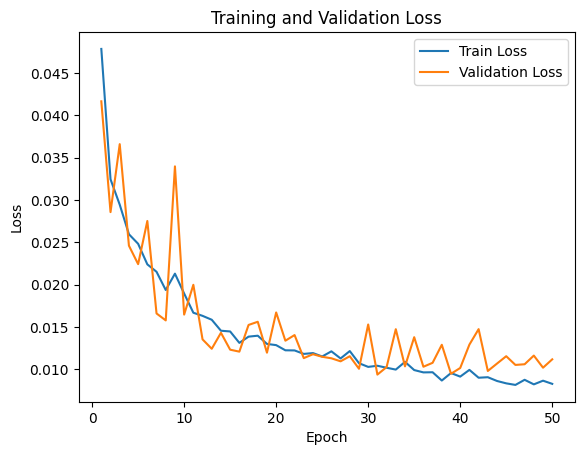

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), [x if x<=0.1 else 0 for x in train_losses], label='Train Loss')
plt.plot(range(1, num_epochs+1), [x if x<=0.1 else 0 for x in val_losses], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_data in test_loader:
        batch_data.to(device)
        
        # Obtener predicciones y targets
        preds = model(batch_data).cpu().numpy()  # Shape: [num_ligands]
        targets = batch_data['ligand'].y.cpu().numpy().squeeze()  # Shape: [num_ligands]
        
        all_preds.append(preds)
        all_targets.append(targets)

# Convertimos listas en arrays 1D (concatenación)
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Verificamos dimensiones
print(f"all_preds shape: {all_preds.shape}, all_targets shape: {all_targets.shape}")
print(all_preds)
print(all_targets)

# Calcular métricas
mse = mean_squared_error(all_targets, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"Test Metrics:\nMSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


all_preds shape: (1804,), all_targets shape: (1804,)
[0.96204823 0.8911574  0.9405932  ... 0.8672709  0.73969114 0.48909068]
[0.95072365 1.         0.9516974  ... 0.74446046 0.7359668  0.5207628 ]
Test Metrics:
MSE: 0.0100, RMSE: 0.1000, MAE: 0.0740, R2: 0.8401


In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(graph_list)):
    print(f"Fold {fold+1}")
    train_graphs = [graph_list[i] for i in train_idx]
    val_graphs = [graph_list[i] for i in val_idx]

    train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=2, shuffle=False)

    model = HeteroGraphScorePredictor(64, 1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch_data in train_loader:
            batch_data.to(device)
            preds = model(batch_data)
            targets = batch_data['ligand'].y.view(-1)
            loss = loss_fn(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss/len(train_loader):.4f}")

    # Evaluación en el fold de validación
    model.eval()
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for batch_data in val_loader:
            batch_data.to(device)
            preds = model(batch_data).cpu().numpy()
            targets = batch_data['ligand'].y.cpu().numpy().squeeze()
            all_val_preds.append(preds)
            all_val_targets.append(targets)
    all_val_preds = np.concatenate(all_val_preds)
    all_val_targets = np.concatenate(all_val_targets)
    fold_r2 = r2_score(all_val_targets, all_val_preds)
    fold_results.append(fold_r2)
    print(f"Fold {fold+1} R²: {fold_r2:.4f}")

print(f"Cross-Validation R² Scores: {fold_results}")
print(f"Mean R²: {np.mean(fold_results):.4f}, Std R²: {np.std(fold_results):.4f}")

In [ ]:
plt.bar(range(1, len(fold_results)+1), fold_results)
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('Cross-Validation R² Scores')
plt.show()